In [155]:
%matplotlib inline
from keras.layers import Input, Dense, Lambda, merge, Embedding, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.objectives import binary_crossentropy
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np

In [35]:
batch_size = 256
original_dim = 784
intermediate_dim = 256
latent_dim = 32
epsilon_std = 1
nb_epoch = 50

x = Input((original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim),
                              mean=0., std=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

In [36]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)

    return recon + kl




vae.compile(optimizer='adadelta', loss=vae_loss)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        verbose=2,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
2s - loss: 220.2458 - val_loss: 166.0347
Epoch 2/50
1s - loss: 153.3418 - val_loss: 141.2353
Epoch 3/50
1s - loss: 135.5525 - val_loss: 128.7800
Epoch 4/50
1s - loss: 126.7254 - val_loss: 122.5000
Epoch 5/50
1s - loss: 120.9129 - val_loss: 117.0878
Epoch 6/50
1s - loss: 116.7346 - val_loss: 114.0122
Epoch 7/50
1s - loss: 113.3615 - val_loss: 111.6732
Epoch 8/50
1s - loss: 110.5474 - val_loss: 109.0626
Epoch 9/50
1s - loss: 108.3619 - val_loss: 106.3541
Epoch 10/50
2s - loss: 106.5801 - val_loss: 104.8310
Epoch 11/50
2s - loss: 105.0341 - val_loss: 104.2725
Epoch 12/50
1s - loss: 103.7626 - val_loss: 102.2716
Epoch 13/50
1s - loss: 102.6721 - val_loss: 101.3687
Epoch 14/50
1s - loss: 101.7341 - val_loss: 101.6368
Epoch 15/50
1s - loss: 100.8149 - val_loss: 100.2509
Epoch 16/50
1s - loss: 100.0782 - val_loss: 99.4330
Epoch 17/50
1s - loss: 99.3760 - val_loss: 98.2676
Epoch 18/50
2s - loss: 98.7821 - val_loss: 97.7390
Epoch 19/5

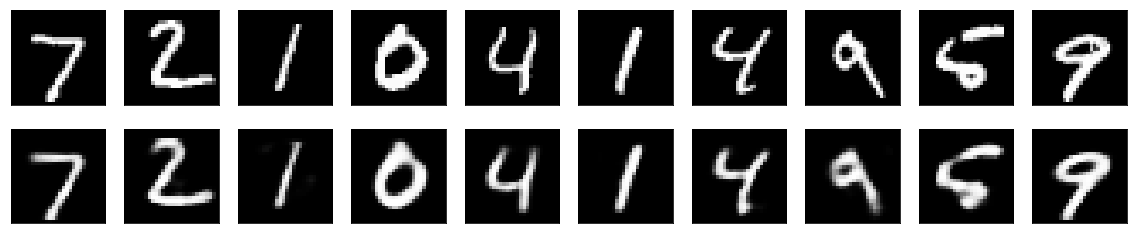

In [37]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

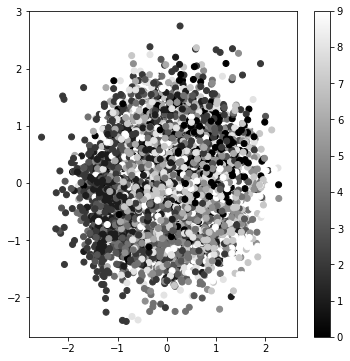

In [38]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# Keras's implementation

# Agustinus Kristiadi's Implementation
https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/


In [172]:

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf


m = 1024
n_z = 32
n_epoch = 15

class VAE():

    def __init__(self, input_dim, hidden_dim=256, latent_dim=32):
        
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        
        # Q(z|X) -- encoder
        inputs = Input(shape=(input_dim,))
        h_q = Dense(hidden_dim, activation='relu')(inputs)
        mu = Dense(latent_dim, activation='linear')(h_q)
        log_sigma = Dense(latent_dim, activation='linear')(h_q)

        def sample_z(args):
            mu, log_sigma = args
            batch = K.shape(mu)[0]
            dim = K.int_shape(mu)[1]
            eps = K.random_normal(shape=(batch, dim), mean=0., std=1.)
            return mu + K.exp(log_sigma / 2) * eps



        # Sample z ~ Q(z|X)
        z = Lambda(sample_z)([mu, log_sigma])

        # P(X|z) -- decoder
        decoder_hidden = Dense(hidden_dim, activation='relu')
        decoder_out = Dense(input_dim, activation='sigmoid')

        h_p = decoder_hidden(z)
        outputs = decoder_out(h_p)

        # Overall VAE model, for reconstruction and training
        self.model = Model(inputs, outputs)

        # Encoder model, to encode input into latent variable
        # We use the mean as the output as it is the center point, the representative of the gaussian
        self.encoder = Model(inputs, mu)

        # Generator model, generate new data given latent variable z
        d_in = Input(shape=(latent_dim,))
        d_h = decoder_hidden(d_in)
        d_out = decoder_out(d_h)
        self.decoder = Model(d_in, d_out)

        def vae_loss(y_true, y_pred):
            """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
            # E[log P(X|z)]
            recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
            # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
            kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

            return recon + kl
        
        self.model.compile(optimizer='adam', loss=vae_loss)
        
        


# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# vae = VAE(784, 256, 32)

# vae.model.fit(x_train, x_train, batch_size=m, nb_epoch=n_epoch, verbose=2, validation_split=0.2)

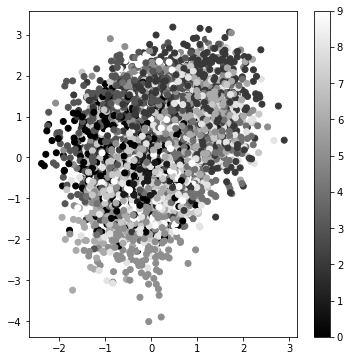

In [55]:
x_test_encoded = vae.encoder.predict(x_test)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


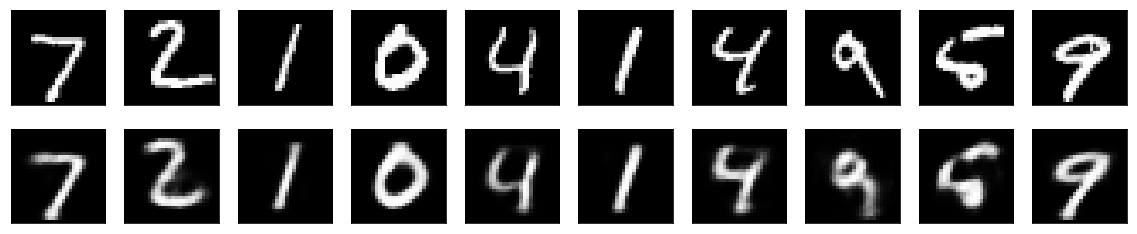

In [56]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = vae.encoder.predict(x_test)
decoded_imgs = vae.decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [57]:
import pandas as pd

In [58]:
TRAIN_DATA_FILE = '/data/chzho/deepqts/train_data/unifiedclick/join_oneyearsample_2B_training_all_top10'
TEST_DATA_FILE = '/data/chzho/deepqts/test_data/uhrs/unified/uhrs_do_10'
batch_size = 1000
MAX_SEQUENCE_LENGTH = 5
MAX_NB_WORDS = 50000


In [59]:
%%time
num_read_row = 100000
df = pd.read_csv(TRAIN_DATA_FILE, sep="\t", usecols=[0,1,3], names=['label', 'q', 'd'], header=None , error_bad_lines=False, nrows=num_read_row)
df = df.dropna()

CPU times: user 1.01 s, sys: 196 ms, total: 1.2 s
Wall time: 1.12 s


In [60]:
texts = df.q.tolist() + df.d.tolist()

# TF-IDF features

In [62]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(max_features=MAX_NB_WORDS)
x_train = count_vect.fit_transform(texts)
tf_transformer = TfidfTransformer().fit(x_train)
x_train = tf_transformer.transform(x_train)
y_train = df.label.values

CPU times: user 2.84 s, sys: 264 ms, total: 3.1 s
Wall time: 2.79 s


In [71]:
x_train = x_train.todense()

In [73]:
text_vae = VAE(MAX_NB_WORDS)

In [77]:
text_vae.model.fit(x_train, x_train, batch_size=m, nb_epoch=n_epoch, verbose=2, validation_split=0.2)

Train on 160000 samples, validate on 40000 samples
Epoch 1/15
261s - loss: 1140.6824 - val_loss: 62.6132
Epoch 2/15
244s - loss: 49.7789 - val_loss: 49.8124
Epoch 3/15
246s - loss: 41.1500 - val_loss: 42.3956
Epoch 4/15
249s - loss: 36.5805 - val_loss: 38.7982
Epoch 5/15
250s - loss: 34.3501 - val_loss: 36.9701
Epoch 6/15
252s - loss: 33.0301 - val_loss: 35.9837
Epoch 7/15
251s - loss: 32.1876 - val_loss: 35.3331
Epoch 8/15
253s - loss: 31.6129 - val_loss: 34.8968
Epoch 9/15
255s - loss: 31.1895 - val_loss: 34.1168
Epoch 10/15
255s - loss: 30.8012 - val_loss: 34.0413
Epoch 11/15
257s - loss: 30.5628 - val_loss: 33.6279
Epoch 12/15
258s - loss: 30.2496 - val_loss: 33.4836
Epoch 13/15
259s - loss: 30.0606 - val_loss: 33.2419
Epoch 14/15
256s - loss: 29.8500 - val_loss: 33.1593
Epoch 15/15
253s - loss: 29.6335 - val_loss: 32.6520


In [87]:
text_vae.model.save_weights("text_vae_on_small_data.weights.h5")

In [88]:
text_vae.model.save("text_vae_on_small_data.h5")

In [82]:
class MLP():
    def __init__(self, input_dim, latent_dim=256):

        que_input = Input(shape=(input_dim,))
        doc_input = Input(shape=(input_dim,))

        concat = merge([que_input, doc_input], mode="concat")


        hidden_layer = Dense(latent_dim, activation='relu')(concat)
        pred = Dense(1, activation='sigmoid')(hidden_layer)

        self.model = Model(input=[que_input, doc_input], output=pred)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [79]:
%%time
import pandas as pd
df_test = pd.read_csv(TEST_DATA_FILE, sep="\t", usecols=[0,1,3], names=['label', 'q', 'd'], header=None , error_bad_lines=False)
df_test = df_test.dropna()

CPU times: user 7.3 s, sys: 888 ms, total: 8.19 s
Wall time: 7.47 s


## TODO: Testing dataset contains lot of non-english words

In [107]:
# test_sample_num = 5000
# q_train = tf_transformer.transform(df_test_small.q.tolist()[:test_sample_num])
# d_train = tf_transformer.transform(df_test_small.d.tolist()[:test_sample_num])
# y_train = df_test_small.label.values[:test_sample_num]


In [109]:
y_train.shape

(100000,)

In [111]:
mlp = MLP(MAX_NB_WORDS)
mlp.model.fit([x_train[:100000], x_train[100000:]], y_train, batch_size=m, nb_epoch=2, verbose=2, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/2
157s - loss: 0.6309 - acc: 0.6257 - val_loss: 0.6019 - val_acc: 0.6520
Epoch 2/2
120s - loss: 0.4896 - acc: 0.7790 - val_loss: 0.6450 - val_acc: 0.6344


In [114]:
%%time
enc_q_train = text_vae.encoder.predict(x_train[:100000])
enc_d_train = text_vae.encoder.predict(x_train[100000:])


CPU times: user 1min 16s, sys: 16.3 s, total: 1min 33s
Wall time: 1min 14s


In [119]:
mlp = MLP(32) # use text_vae.latent_dim
mlp.model.fit([enc_q_train, enc_d_train], y_train, batch_size=m, nb_epoch=100, verbose=2, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
1s - loss: 0.6890 - acc: 0.5340 - val_loss: 0.6850 - val_acc: 0.5546
Epoch 2/100
0s - loss: 0.6831 - acc: 0.5482 - val_loss: 0.6876 - val_acc: 0.5551
Epoch 3/100
0s - loss: 0.6804 - acc: 0.5538 - val_loss: 0.6768 - val_acc: 0.5736
Epoch 4/100
0s - loss: 0.6773 - acc: 0.5604 - val_loss: 0.6751 - val_acc: 0.5742
Epoch 5/100
0s - loss: 0.6748 - acc: 0.5621 - val_loss: 0.6725 - val_acc: 0.5746
Epoch 6/100
0s - loss: 0.6738 - acc: 0.5649 - val_loss: 0.6718 - val_acc: 0.5758
Epoch 7/100
0s - loss: 0.6724 - acc: 0.5645 - val_loss: 0.6751 - val_acc: 0.5526
Epoch 8/100
0s - loss: 0.6740 - acc: 0.5635 - val_loss: 0.6752 - val_acc: 0.5524
Epoch 9/100
0s - loss: 0.6719 - acc: 0.5653 - val_loss: 0.6695 - val_acc: 0.5783
Epoch 10/100
0s - loss: 0.6698 - acc: 0.5667 - val_loss: 0.6673 - val_acc: 0.5723
Epoch 11/100
0s - loss: 0.6702 - acc: 0.5670 - val_loss: 0.6663 - val_acc: 0.5763
Epoch 12/100
0s - loss: 0.6687 - acc: 0.5680 - val_loss: 

# Glove Feature Experiments

In [129]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 5

In [123]:
tokenizer = Tokenizer(MAX_NB_WORDS)
tokenizer.fit_on_texts(df.q.tolist() + df.d.tolist())
word_index = tokenizer.word_index #the dict values start from 1 so this is fine with zeropadding
index2word = {v: k for k, v in word_index.items()}
print('Found %s unique tokens' % len(word_index))
NB_WORDS = (min(tokenizer.nb_words, len(word_index)) + 1 ) #+1 for zero padding
print('Number of Vocab: %d' % NB_WORDS)

Found 137282 unique tokens
Number of Vocab: 50001


In [124]:
GLOVE_EMBEDDING = '/home/t-jamano/data/glove/glove.6B.50d.txt'
embeddings_index = {}
f = open(GLOVE_EMBEDDING, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


glove_embedding_matrix = np.zeros((NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < NB_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be the word embedding of 'unk'.
            glove_embedding_matrix[i] = embedding_vector
        else:
            glove_embedding_matrix[i] = embeddings_index.get('unk')
print('Null word embeddings: %d' % np.sum(np.sum(glove_embedding_matrix, axis=1) == 0))

Found 400000 word vectors.
Null word embeddings: 1


### add pre-trained w2v into keras Embedding layer

In [149]:
# w2vVectorisor = Sequential()
# w2vVectorisor.add(Embedding(NB_WORDS, EMBEDDING_DIM, weights=glove_embedding_matrix[0],
#                             input_length=MAX_SEQUENCE_LENGTH, trainable=False))

## Keras w2v model

In [156]:

class W2vVectorisor():
    def __init__(self, input_dim):
        
        self.input_dim = input_dim
        x_input = Input((self.input_dim,))
        self.embed = Embedding(NB_WORDS, EMBEDDING_DIM, weights=glove_embedding_matrix,
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)
        pred = Flatten()(embed(x_input))
        
        self.model = Model(x_input, pred)
        
        
w2vVectorisor = W2vVectorisor(MAX_SEQUENCE_LENGTH)


In [162]:
x_train = tokenizer.texts_to_sequences(texts)
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)

In [163]:
x_w2v_train = w2vVectorisor.model.predict(x_train)

In [159]:
w2v_vae = VAE(EMBEDDING_DIM * MAX_SEQUENCE_LENGTH)

In [160]:
w2v_vae.model.fit(x_w2v_train, x_w2v_train, batch_size=m, nb_epoch=n_epoch, verbose=2, validation_split=0.2)

Train on 160000 samples, validate on 40000 samples
Epoch 1/15
2s - loss: 22.5907 - val_loss: 1.4073
Epoch 2/15
1s - loss: -3.3560e+00 - val_loss: -1.9822e-01
Epoch 3/15
1s - loss: -5.0591e+00 - val_loss: -1.7543e+00
Epoch 4/15
1s - loss: -6.6564e+00 - val_loss: -3.3193e+00
Epoch 5/15
1s - loss: -7.7032e+00 - val_loss: -3.9780e+00
Epoch 6/15
1s - loss: -8.1868e+00 - val_loss: -4.2386e+00
Epoch 7/15
1s - loss: -8.5107e+00 - val_loss: -4.4075e+00
Epoch 8/15
1s - loss: -8.7314e+00 - val_loss: -4.5168e+00
Epoch 9/15
1s - loss: -8.8602e+00 - val_loss: -4.5977e+00
Epoch 10/15
1s - loss: -8.9463e+00 - val_loss: -4.6420e+00
Epoch 11/15
1s - loss: -8.9926e+00 - val_loss: -4.6825e+00
Epoch 12/15
1s - loss: -9.0268e+00 - val_loss: -4.7263e+00
Epoch 13/15
1s - loss: -9.0610e+00 - val_loss: -4.7633e+00
Epoch 14/15
1s - loss: -9.0890e+00 - val_loss: -4.7787e+00
Epoch 15/15
1s - loss: -9.1191e+00 - val_loss: -4.8106e+00


In [173]:
x_w2v_enc_train = w2v_vae.encoder.predict(x_w2v_train)

In [177]:
w2v_mlp = MLP(EMBEDDING_DIM * MAX_SEQUENCE_LENGTH)
w2v_mlp.model.fit([x_w2v_train[:100000], x_w2v_train[100000:]], y_train, batch_size=m, nb_epoch=50, verbose=2, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
1s - loss: 0.6462 - acc: 0.6115 - val_loss: 0.6321 - val_acc: 0.6194
Epoch 2/50
0s - loss: 0.6258 - acc: 0.6292 - val_loss: 0.6286 - val_acc: 0.6207
Epoch 3/50
0s - loss: 0.6206 - acc: 0.6339 - val_loss: 0.6253 - val_acc: 0.6231
Epoch 4/50
0s - loss: 0.6160 - acc: 0.6375 - val_loss: 0.6229 - val_acc: 0.6274
Epoch 5/50
0s - loss: 0.6120 - acc: 0.6409 - val_loss: 0.6230 - val_acc: 0.6264
Epoch 6/50
0s - loss: 0.6073 - acc: 0.6461 - val_loss: 0.6193 - val_acc: 0.6317
Epoch 7/50
0s - loss: 0.6027 - acc: 0.6515 - val_loss: 0.6194 - val_acc: 0.6310
Epoch 8/50
0s - loss: 0.5980 - acc: 0.6580 - val_loss: 0.6172 - val_acc: 0.6329
Epoch 9/50
0s - loss: 0.5932 - acc: 0.6619 - val_loss: 0.6187 - val_acc: 0.6301
Epoch 10/50
0s - loss: 0.5884 - acc: 0.6677 - val_loss: 0.6156 - val_acc: 0.6344
Epoch 11/50
0s - loss: 0.5828 - acc: 0.6746 - val_loss: 0.6149 - val_acc: 0.6340
Epoch 12/50
0s - loss: 0.5770 - acc: 0.6821 - val_loss: 0.6163 - val

In [176]:
w2v_mlp = MLP(32)
w2v_mlp.model.fit([x_w2v_enc_train[:100000], x_w2v_enc_train[100000:]], y_train, batch_size=m, nb_epoch=50, verbose=2, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
1s - loss: 0.6627 - acc: 0.5769 - val_loss: 0.6604 - val_acc: 0.5812
Epoch 2/50
0s - loss: 0.6527 - acc: 0.5907 - val_loss: 0.6538 - val_acc: 0.5951
Epoch 3/50
0s - loss: 0.6483 - acc: 0.5989 - val_loss: 0.6523 - val_acc: 0.6000
Epoch 4/50
0s - loss: 0.6447 - acc: 0.6057 - val_loss: 0.6483 - val_acc: 0.6017
Epoch 5/50
0s - loss: 0.6420 - acc: 0.6112 - val_loss: 0.6445 - val_acc: 0.6067
Epoch 6/50
0s - loss: 0.6399 - acc: 0.6143 - val_loss: 0.6428 - val_acc: 0.6100
Epoch 7/50
0s - loss: 0.6382 - acc: 0.6166 - val_loss: 0.6409 - val_acc: 0.6119
Epoch 8/50
0s - loss: 0.6373 - acc: 0.6173 - val_loss: 0.6415 - val_acc: 0.6107
Epoch 9/50
0s - loss: 0.6365 - acc: 0.6179 - val_loss: 0.6403 - val_acc: 0.6127
Epoch 10/50
0s - loss: 0.6359 - acc: 0.6173 - val_loss: 0.6400 - val_acc: 0.6110
Epoch 11/50
0s - loss: 0.6355 - acc: 0.6179 - val_loss: 0.6395 - val_acc: 0.6106
Epoch 12/50
0s - loss: 0.6346 - acc: 0.6187 - val_loss: 0.6382 - val

# IMDB experiments

In [182]:
from keras.datasets import imdb

MAX_LENGTH = 300
NUM_WORDS = 1000

In [186]:

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=NUM_WORDS)


In [192]:
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

In [198]:
from keras import objectives, backend as K
from keras.layers import Bidirectional, Dense, Embedding, Input, Lambda, LSTM, RepeatVector, TimeDistributed
from keras.models import Model
import keras

In [204]:
class LSTM_VAE(object):
    def create(self, vocab_size=500, max_length=300, latent_rep_size=200):
        self.encoder = None
        self.decoder = None
        self.sentiment_predictor = None
        self.autoencoder = None

        x = Input(shape=(max_length,))
        x_embed = Embedding(vocab_size, 64, input_length=max_length)(x)

        vae_loss, encoded = self._build_encoder(x_embed, latent_rep_size=latent_rep_size, max_length=max_length)
        self.encoder = Model(x, encoded)

        encoded_input = Input(shape=(latent_rep_size,))
        predicted_sentiment = self._build_sentiment_predictor(encoded_input)
        self.sentiment_predictor = Model(encoded_input, predicted_sentiment)

        decoded = self._build_decoder(encoded_input, vocab_size, max_length)
        self.decoder = Model(encoded_input, decoded)

        self.autoencoder = Model(x, [self._build_decoder(encoded, vocab_size, max_length), self._build_sentiment_predictor(encoded)])
        self.autoencoder.compile(optimizer='Adam',
                                 loss=[vae_loss, 'binary_crossentropy'],
                                 metrics=['accuracy'])
        
    def _build_encoder(self, x, latent_rep_size=200, max_length=300, epsilon_std=0.01):
        h = Bidirectional(LSTM(500, return_sequences=True, name='lstm_1'), merge_mode='concat')(x)
        h = Bidirectional(LSTM(500, return_sequences=False, name='lstm_2'), merge_mode='concat')(h)
        h = Dense(435, activation='relu', name='dense_1')(h)

        def sampling(args):
            z_mean_, z_log_var_ = args
            batch_size = K.shape(z_mean_)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_rep_size), mean=0., std=epsilon_std)
            return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

        z_mean = Dense(latent_rep_size, name='z_mean', activation='linear')(h)
        z_log_var = Dense(latent_rep_size, name='z_log_var', activation='linear')(h)

        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return xent_loss + kl_loss

        return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,), name='lambda')([z_mean, z_log_var]))
    
    def _build_decoder(self, encoded, vocab_size, max_length):
        repeated_context = RepeatVector(max_length)(encoded)

        h = LSTM(500, return_sequences=True, name='dec_lstm_1')(repeated_context)
        h = LSTM(500, return_sequences=True, name='dec_lstm_2')(h)

        decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)

        return decoded
    
    def _build_sentiment_predictor(self, encoded):
        h = Dense(100, activation='linear')(encoded)

        return Dense(1, activation='sigmoid', name='pred')(h)

In [205]:
lstm_vae = LSTM_VAE()
lstm_vae.create(NUM_WORDS, MAX_LENGTH)

/home/t-jamano/.local/lib/python3.6/site-packages/keras/engine/topology.py:368: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of '


In [208]:
temp = np.zeros((X_train.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_train.shape[0]), axis=0).reshape(X_train.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_train.shape[0], axis=0), X_train] = 1

X_train_one_hot = temp

In [ ]:
lstm_vae.autoencoder.fit(X_train, [X_train_one_hot, y_train], verbose=2)

Epoch 1/10
